# **Matching**

**Notes:**

- **Causal Effect of Treament on the Treated** is what we're trying to measure.
- We may not be able to exactly match on the full set of covariates, neither are they in randomized controlled trials.
    - The distribution of covariates is **balanced** between groups (stochastic balance).


- **Fine Balance**
    - Same challenge when it comes to matching, when it's difficult to find exact matches, we should be willing to accept some non-ideal matches if treated and control groups have **same distribution of covariates.**
    - Number of matches:
        - One to one (pair matching)
        - Many to one (k controls to every treated subject)
        - Variable matching (k>=0 and varies for every treated subject)
   

- **Distance Measures**
    - Mahalanobis Distance (Robust Mahalanobis Distance, rank based)
        - If there are few important covariates, make their distance infinity if they're not equal.
    
    
 - [**Greedy Matching**](https://www.statisticshowto.com/greedy-algorithm-matching/)
    - Nearest neighbor matching
    - Specifically greedy because the smallest distance match **does not minimize total distance** between all pairs; can lead to bad matches; depends on initial list order.
    
- **Caliper**
    - Maximum acceptable distance
    - We might want to exclude treated subjects for whom there does not exist a good match.
    - Why? Or else might violate [**positivity assumption**](https://medium.com/@EpiEllie/positivity-what-it-is-and-why-it-matters-for-data-science-d5e9c0bc1fcb) 
        - The probability of having a particular level of exposure, conditional on your covariates, is greater than 0 and less than 1, for all strata and exposure levels of interest.
        - If you want to compare two types of exposures, then you have to have people in your data who are able to & sometimes will receive any or all of the relevant exposure values!


- **Optimal Matching**
    - Minimizes global distance measure
    - Computationally demanding (Assignment optimization problem)
        - Sparse optimal matching for larger datasets, by matching within **blocks**, where fine balance is prioritized and is achievable.


- **Variables for Matching**
    - Could be based directly on confounders/covariates, or
    - **Propensity Scores from the model**
        - Probability of receiving treatment
        - Acts as a singular balancing score
        - Conditioning on the estimated propensity score, is conditioning on an **allocation probability**
        - Logit (log-odds) of the propensity score is practically used.


- **Balance Measures**
    - Hypothesis tests of means
    - Standardized mean differences (mean differences divided by pooled standard deviation)
        - <0.1 good balance, >0.2 imbalance

- **Post Matching Analysis**
    - McNemar Chi-squared test for paired data
    - Paired t-test for continuous data
    - Conditional Logistic Regression for paired binary outcome data
    - Stratified Cox model for time-to-event survival outcome data (stratify baseline model based on match_id variable)
    - Generalized estimating equations (GEE) for binary outcomes, a causal risk difference, risk ratio, odds ratio (clusters based on match_id variable)
 
 
- [**Hidden Bias: Sensitivity Analysis**](https://documentation.sas.com/doc/en/pgmsascdc/v_022/statug/statug_psmatch_details30.htm)
    - [**ignorability assumption**](https://www.fragilefamilieschallenge.org/causal-inference/)
    - Odds ratio is bounded by:
    
        ![image](https://documentation.sas.com/api/docsets/statug/v_014/content/images/statug_psmatch_eqn_0111.svg?locale=en)
    - If `gamma` is large before which treatment effect vanishes away, then we can be confident in the study results.

In [1]:
#install needed libraries
install.packages("tableone")
install.packages("Matching")
install.packages("MatchIt")

Installing package into ‘/home/starscream/R/x86_64-pc-linux-gnu-library/4.1’
(as ‘lib’ is unspecified)

Installing package into ‘/home/starscream/R/x86_64-pc-linux-gnu-library/4.1’
(as ‘lib’ is unspecified)

Installing package into ‘/home/starscream/R/x86_64-pc-linux-gnu-library/4.1’
(as ‘lib’ is unspecified)



## **Load Libraries and Data**

In [2]:
library(tableone)
library(Matching)
library(MatchIt)

Loading required package: MASS

## 
##  Matching (Version 4.9-11, Build Date: 2021-10-18)
##  See http://sekhon.berkeley.edu/matching for additional documentation.
##  Please cite software as:
##   Jasjeet S. Sekhon. 2011. ``Multivariate and Propensity Score Matching
##   Software with Automated Balance Optimization: The Matching package for R.''
##   Journal of Statistical Software, 42(7): 1-52. 
##




In [3]:
data("lalonde")
lalonde$race_black = ifelse(lalonde$race=='black', 1, 0)
lalonde$race_hisp = ifelse(lalonde$race=='hispan', 1, 0)
head(lalonde)

,treat,age,educ,race,married,nodegree,re74,re75,re78,race_black,race_hisp
,<int>,<int>,<int>,<fct>,<int>,<int>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
NSW1,1,37,11,black,1,1,0,0,9930.0460,1,0
NSW2,1,22,9,hispan,0,1,0,0,3595.8940,0,1
NSW3,1,30,12,black,0,0,0,0,24909.4500,1,0
NSW4,1,27,11,black,0,1,0,0,7506.1460,1,0
NSW5,1,33,8,black,0,1,0,0,289.7899,1,0
NSW6,1,22,9,black,0,1,0,0,4056.4940,1,0



Call:
matchit(formula = treat ~ age + educ + race_black + race_hisp + 
    married + nodegree + re74 + re75, data = lalonde, method = NULL, 
    distance = "glm")

Summary of Balance for All Data:
           Means Treated Means Control Std. Mean Diff. Var. Ratio eCDF Mean
distance          0.5774        0.1822          1.7941     0.9211    0.3774
age              25.8162       28.0303         -0.3094     0.4400    0.0813
educ             10.3459       10.2354          0.0550     0.4959    0.0347
race_black        0.8432        0.2028          1.7615          .    0.6404
race_hisp         0.0595        0.1422         -0.3498          .    0.0827
married           0.1892        0.5128         -0.8263          .    0.3236
nodegree          0.7081        0.5967          0.2450          .    0.1114
re74           2095.5737     5619.2365         -0.7211     0.5181    0.2248
re75           1532.0553     2466.4844         -0.2903     0.9563    0.1342
           eCDF Max
distance     0.6444
ag

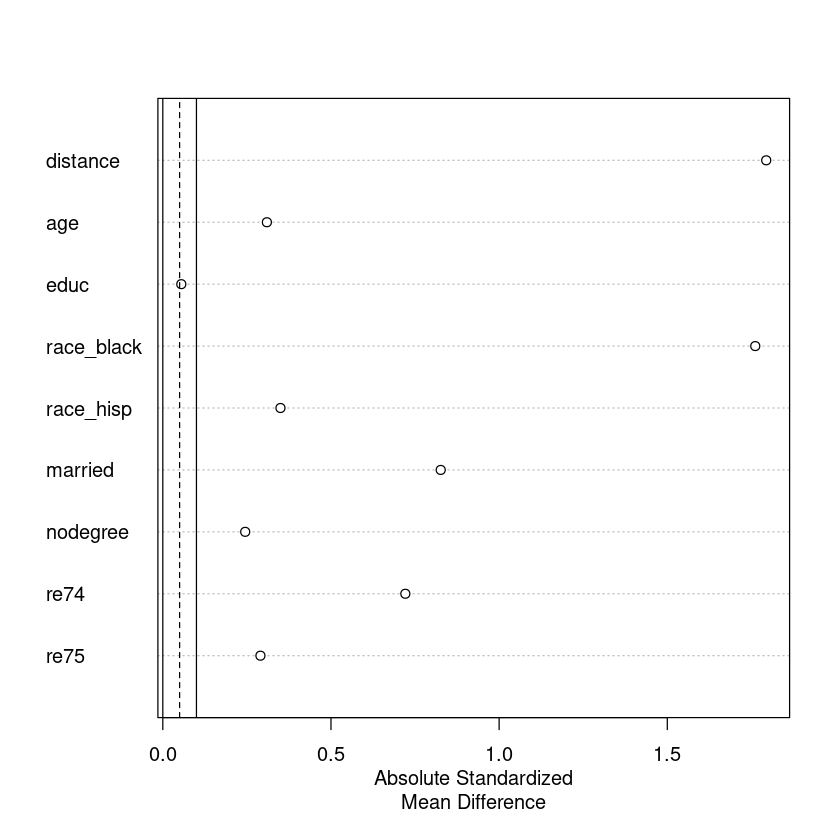

In [4]:
# using match it
# https://cran.r-project.org/web/packages/MatchIt/vignettes/MatchIt.html#fn2
covar_table_0 <- matchit(treat ~ age + educ + race_black + race_hisp + married + 
                   nodegree + re74 + re75, data = lalonde,
                 method = NULL, distance = "glm") #method = NULL, to assess balance prior to matching
summary(covar_table_0)
plot(summary(covar_table_0))

In [5]:
#using table one
#covariates we will use (shorter list than you would use in practice)
covariates <-c ("age","educ", "race_black", "race_hisp", "married","nodegree","re74","re75")

covar_table_1 <- CreateTableOne(vars=covariates,strata="treat", data=lalonde, test=FALSE)
# include standardized mean difference (SMD)
print(covar_table_1,smd=TRUE)

                        Stratified by treat
                         0                 1                 SMD   
  n                          429               185                 
  age (mean (SD))          28.03 (10.79)     25.82 (7.16)     0.242
  educ (mean (SD))         10.24 (2.86)      10.35 (2.01)     0.045
  race_black (mean (SD))    0.20 (0.40)       0.84 (0.36)     1.668
  race_hisp (mean (SD))     0.14 (0.35)       0.06 (0.24)     0.277
  married (mean (SD))       0.51 (0.50)       0.19 (0.39)     0.719
  nodegree (mean (SD))      0.60 (0.49)       0.71 (0.46)     0.235
  re74 (mean (SD))       5619.24 (6788.75) 2095.57 (4886.62)  0.596
  re75 (mean (SD))       2466.48 (3292.00) 1532.06 (3219.25)  0.287


## **Greedy Matching**
- **Directly on Confounders/Covariates**
- Nearest Neighbor matching
- Measure: Mahalanobis distance

In [7]:
greedy_match_dist <- Match(Tr=lalonde$treat,M=1,X=lalonde[covariates],replace=FALSE) #M=k, 1 indicates one-to-one matching, give a larger k for larger samples, many-to-one
greedy_match_dist_pairs <- lalonde[unlist(greedy_match_dist[c("index.treated","index.control")]), ]

#get table 1 for matched data with standardized differences
greedy_match_dist_table <- CreateTableOne(vars=covariates, strata ="treat", 
                            data=greedy_match_dist_pairs, test = FALSE)
print(greedy_match_dist_table, smd = TRUE)

                        Stratified by treat
                         0                 1                 SMD   
  n                          185               185                 
  age (mean (SD))          24.21 (9.55)      25.82 (7.16)     0.190
  educ (mean (SD))         10.23 (2.37)      10.35 (2.01)     0.052
  race_black (mean (SD))    0.43 (0.50)       0.84 (0.36)     0.943
  race_hisp (mean (SD))     0.06 (0.24)       0.06 (0.24)    <0.001
  married (mean (SD))       0.20 (0.40)       0.19 (0.39)     0.027
  nodegree (mean (SD))      0.69 (0.46)       0.71 (0.46)     0.035
  re74 (mean (SD))       2681.77 (4754.79) 2095.57 (4886.62)  0.122
  re75 (mean (SD))       1523.69 (2810.24) 1532.06 (3219.25)  0.003


SMD is better but still not great with the lens of `< 0.2`

### **Analysis**

In [8]:
y_trt <- greedy_match_dist_pairs$re78[greedy_match_dist_pairs$treat==1]
y_con <- greedy_match_dist_pairs$re78[greedy_match_dist_pairs$treat==0]
y_diff <- y_trt - y_con

#paired t-test
t.test(y_diff)


	One Sample t-test

data:  y_diff
t = 1.241, df = 184, p-value = 0.2162
alternative hypothesis: true mean is not equal to 0
95 percent confidence interval:
 -484.9967 2129.7613
sample estimates:
mean of x 
 822.3823 


## **Propensity Scoring**

In [10]:
model_ps <-glm("treat ~ age + educ + race_black+ race_hisp+ married + nodegree + re74 + re75",
    family=binomial(),data=lalonde)
summary(model_ps)


Call:
glm(formula = "treat ~ age + educ + race_black+ race_hisp+ married + nodegree + re74 + re75", 
    family = binomial(), data = lalonde)

Deviance Residuals: 
    Min       1Q   Median       3Q      Max  
-1.7645  -0.4736  -0.2862   0.7508   2.7169  

Coefficients:
              Estimate Std. Error z value Pr(>|z|)    
(Intercept) -4.729e+00  1.017e+00  -4.649 3.33e-06 ***
age          1.578e-02  1.358e-02   1.162  0.24521    
educ         1.613e-01  6.513e-02   2.477  0.01325 *  
race_black   3.065e+00  2.865e-01  10.699  < 2e-16 ***
race_hisp    9.836e-01  4.257e-01   2.311  0.02084 *  
married     -8.321e-01  2.903e-01  -2.866  0.00415 ** 
nodegree     7.073e-01  3.377e-01   2.095  0.03620 *  
re74        -7.178e-05  2.875e-05  -2.497  0.01253 *  
re75         5.345e-05  4.635e-05   1.153  0.24884    
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

(Dispersion parameter for binomial family taken to be 1)

    Null deviance: 751.49  on 613  degrees of freedo

## **Greedy Matching**
- **Propensity Scores from the model**
    - Probability of receiving treatment
    - Acts as a singular balancing score
    - Conditioning on the estimated propensity score, is conditioning on an **allocation probability**.
- Nearest Neighbor matching
- Measure: Mahalanobis distance

In [11]:
scores_ps <- model_ps$fitted.values
summary(scores_ps)

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
0.00908 0.04854 0.12068 0.30130 0.63872 0.85315 

In [12]:
#do greedy matching on logit(PS) using Match without a caliper

logit <- function(p) {log(p)-log(1-p)}
set.seed(931139)
greedy_match_ps <-Match(Tr=lalonde$treat,X=scores_ps, replace=FALSE)
# greedy_match_ps <-Match(Tr=lalonde$treat,M=1,X=logit(scores_ps), replace=FALSE,caliper=.2)
greedy_match_ps_pairs <-lalonde[unlist(greedy_match_ps[c("index.treated","index.control")]), ]
#get standardized differences
greedy_match_ps_table <-CreateTableOne(vars=covariates, strata ="treat", 
                            data=greedy_match_ps_pairs, test = FALSE)
print(greedy_match_ps_table, smd = TRUE)

                        Stratified by treat
                         0                 1                 SMD   
  n                          185               185                 
  age (mean (SD))          25.29 (10.65)     25.82 (7.16)     0.058
  educ (mean (SD))         10.55 (2.71)      10.35 (2.01)     0.084
  race_black (mean (SD))    0.47 (0.50)       0.84 (0.36)     0.852
  race_hisp (mean (SD))     0.21 (0.41)       0.06 (0.24)     0.453
  married (mean (SD))       0.20 (0.40)       0.19 (0.39)     0.027
  nodegree (mean (SD))      0.65 (0.48)       0.71 (0.46)     0.127
  re74 (mean (SD))       2351.12 (4192.62) 2095.57 (4886.62)  0.056
  re75 (mean (SD))       1605.02 (2601.68) 1532.06 (3219.25)  0.025


In [13]:
y_trt <- greedy_match_ps_pairs$re78[greedy_match_ps_pairs$treat==1]
y_con <- greedy_match_ps_pairs$re78[greedy_match_ps_pairs$treat==0]
y_diff <- y_trt - y_con

#paired t-test
t.test(y_diff)


	One Sample t-test

data:  y_diff
t = 1.356, df = 184, p-value = 0.1768
alternative hypothesis: true mean is not equal to 0
95 percent confidence interval:
 -421.9192 2276.5368
sample estimates:
mean of x 
 927.3088 


In [22]:
#do greedy matching on logit(PS) using Match with a caliper

set.seed(931139)
greedy_match_ps <-Match(Tr=lalonde$treat,X=scores_ps, replace=FALSE,caliper=.1)
greedy_match_ps_pairs <-lalonde[unlist(greedy_match_ps[c("index.treated","index.control")]), ]
#get standardized differences
greedy_match_ps_table <-CreateTableOne(vars=covariates, strata ="treat", 
                            data=greedy_match_ps_pairs, test = FALSE)
print(greedy_match_ps_table, smd = TRUE)

                        Stratified by treat
                         0                 1                 SMD   
  n                          111               111                 
  age (mean (SD))          26.27 (11.10)     26.22 (7.18)     0.006
  educ (mean (SD))         10.37 (2.66)      10.25 (2.31)     0.047
  race_black (mean (SD))    0.72 (0.45)       0.74 (0.44)     0.040
  race_hisp (mean (SD))     0.11 (0.31)       0.10 (0.30)     0.029
  married (mean (SD))       0.24 (0.43)       0.24 (0.43)    <0.001
  nodegree (mean (SD))      0.66 (0.48)       0.65 (0.48)     0.019
  re74 (mean (SD))       2704.56 (4759.89) 2250.49 (5746.14)  0.086
  re75 (mean (SD))       1969.10 (3169.08) 1222.25 (3081.19)  0.239


In [23]:
y_trt <- greedy_match_ps_pairs$re78[greedy_match_ps_pairs$treat==1]
y_con <- greedy_match_ps_pairs$re78[greedy_match_ps_pairs$treat==0]
y_diff <- y_trt - y_con

#paired t-test
t.test(y_diff)


	One Sample t-test

data:  y_diff
t = 1.4824, df = 110, p-value = 0.1411
alternative hypothesis: true mean is not equal to 0
95 percent confidence interval:
 -420.0273 2913.6398
sample estimates:
mean of x 
 1246.806 


 - Notice that the total matched pairs has now reduced from **184** to **110** due to the caliper value 0.1